We fetch data from http://ai.stanford.edu/~amaas/data/sentiment/.

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six.moves import xrange, zip, map, filter

%matplotlib inline

In [2]:
import re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

def review_to_wordlist(review, remove_stopwords=False):
    review_text = BeautifulSoup(review, 'lxml').get_text()
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    words = review_text.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return words

In [3]:
import re 
from six.moves import xrange
import os

def get_data(file_dirs, remove_stopwords=False):
    label = []
    txt = []
    comp_re = re.compile('(\d+)_(\d+).txt')
    for file_dir in file_dirs:
        name_list = [x for x in os.listdir(file_dir) if '.txt' in x]
        for x in iter(name_list):
            f = open(os.path.join(file_dir, x), 'r')
            # word_list = review_to_wordlist(f.read(),  remove_stopwords)
            txt.append(f.read())
            f.close()
            obj = comp_re.search(x)
            star = float(obj.group(2))
            if star > 5:
                label.append(1)
            else:
                label.append(0)
    return [txt, label]

In [29]:
%%time
train_unlabeled = get_data(['./aclImdb/train/unsup'], remove_stopwords=True)

CPU times: user 21.9 s, sys: 680 ms, total: 22.6 s
Wall time: 22.6 s


In [30]:
%%time
train_labeled = get_data(['./aclImdb/train/pos', './aclImdb/train/neg'], remove_stopwords=True)

CPU times: user 11.3 s, sys: 284 ms, total: 11.6 s
Wall time: 11.6 s


In [31]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = "word", 
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 5000) 

In [32]:
def convert_data(data):
    new_data = []
    for x in data:
        new_data.append(' '.join(x))
    return new_data

In [34]:
from sklearn.preprocessing import normalize

def get_bow(vectorizer, data):
    data = convert_data(data)
    bow = vectorizer.transform(data)
    bow = normalize(bow, norm='l2', axis=1)
    return bow

In [36]:
%%time

vectorizer.fit(convert_data(train_labeled[0]))

CPU times: user 2.49 s, sys: 20 ms, total: 2.51 s
Wall time: 2.43 s


CountVectorizer(analyzer='word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [37]:
bow = get_bow(vectorizer, train_labeled[0])

/home/tomoaki/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


In [11]:
from sklearn.preprocessing import normalize

bow = normalize(bow, norm='l2', axis=1)

/home/tomoaki/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


In [38]:
np.max(bow)

0.86692144686301076

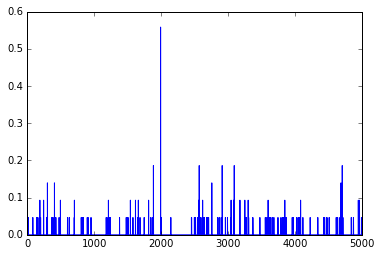

In [39]:
plt.plot(bow.toarray()[0])

In [59]:
%%time

from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 1000) 
forest.fit(bow, train_labeled[1])

CPU times: user 7min 1s, sys: 76 ms, total: 7min 1s
Wall time: 7min 1s


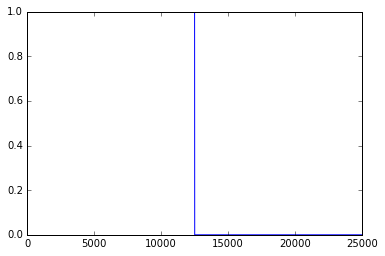

In [60]:
plt.plot(forest.predict(bow))

In [61]:
%%time
test_data = get_data(['./aclImdb/test/pos', './aclImdb/test/neg'], remove_stopwords=True)

CPU times: user 11.1 s, sys: 368 ms, total: 11.4 s
Wall time: 11.3 s


In [62]:
test_input, test_label = test_data
# vectorizer.fit([' '.join(x)  for x in labeled_data[0]])
test_bow = get_bow(vectorizer, test_input)

/home/tomoaki/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


In [63]:
output = forest.predict(test_bow)

In [64]:
def accuracy(prediction, target):
    return 1 - np.mean(np.abs(prediction - target))

# Neural Network

In [4]:
import re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import nltk

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def review_to_sentences(review, remove_stopwords=False):
    review = BeautifulSoup(review, 'lxml').get_text()
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentences) == 0:
            continue
        sentences.append(review_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

In [5]:
%%time
train_unlabeled = get_data(['./aclImdb/train/unsup'], remove_stopwords=False)
train_labeled = get_data(['./aclImdb/train/pos', './aclImdb/train/neg'], remove_stopwords=False)

CPU times: user 12.4 s, sys: 12.6 s, total: 25.1 s
Wall time: 2min 32s


In [6]:
def get_sentnces(data):
    sentences = []
    labels = []
    ids = []
    for idx, x in enumerate(data[0]):
        _sentences = review_to_sentences(x)
        if len(_sentences) == 0:
            continue
        sentences += _sentences
        labels += [data[1][idx]] * len(_sentences)
        ids += [idx]*len(_sentences)
    return sentences, labels, ids

In [7]:
%%time
unlabeled_sentences, _, unlabeled_ids = get_sentnces(train_unlabeled)

/Users/tomoaki/anaconda/lib/python3.5/site-packages/bs4/__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)
/Users/tomoaki/anaconda/lib/python3.5/site-packages/bs4/__init__.py:219: UserWarning: "b'..'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)
/Users/tomoaki/anaconda/lib/python3.5/site-packages/bs4/__init__.py:282: UserWarning: "http://www.msnbc.msn.com/id/4972055/site/newsweek/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/tomoaki/anaconda/lib/python3.5/site-packages/bs4/__init__.py:282: UserWarning: "http://www.archive.org/details/LovefromaStranger" looks lik

CPU times: user 4min 2s, sys: 13.2 s, total: 4min 16s
Wall time: 4min 29s


In [8]:
print(len(unlabeled_ids), len(unlabeled_sentences), len(_))

539863 539863 539863


In [9]:
import warnings

warnings.filterwarnings("ignore")

In [10]:
%%time
labeled_sentences, labeled_labels, labeled_ids = get_sentnces(train_labeled)

CPU times: user 2min 4s, sys: 10.7 s, total: 2min 15s
Wall time: 2min 27s


In [70]:
length = [len(x) for x in labeled_sentences]

In [71]:
np.mean(length)

21.774920465620919

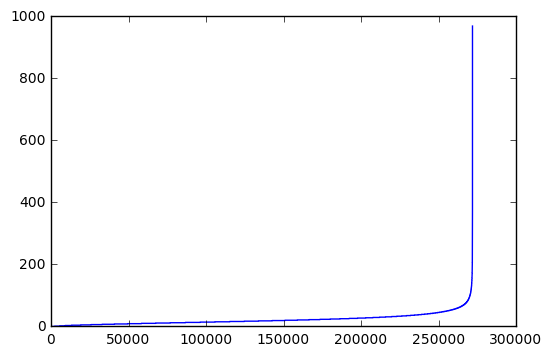

In [72]:
plt.plot(sorted(length))

In [73]:
np.median(length)

18.0

In [11]:
%%time

from gensim.models.word2vec import Word2Vec

model = Word2Vec(unlabeled_sentences + labeled_sentences, size=100, 
                 window=5, min_count=5, workers=4, max_vocab_size=50000)

CPU times: user 4min 17s, sys: 8.57 s, total: 4min 25s
Wall time: 1min 52s


In [19]:
model.most_similar('woman')

[('girl', 0.8215048313140869),
 ('man', 0.7676840424537659),
 ('lady', 0.7582483291625977),
 ('prostitute', 0.7243772745132446),
 ('widow', 0.7123724222183228),
 ('teenager', 0.7024355530738831),
 ('nun', 0.6729723811149597),
 ('person', 0.6613528728485107),
 ('monk', 0.6577709913253784),
 ('child', 0.6573684811592102)]

In [20]:
model.syn0.shape

(29494, 100)

In [21]:
vocab = dict([(k, v.index) for k, v in model.vocab.items()])

In [22]:
word_list = []
for x in labeled_sentences:
    word_list += x

In [23]:
%%time

def word2index(word):
    try:
        return vocab[word]
    except:
        return None
index = map(word2index, word_list)

CPU times: user 9 µs, sys: 1 µs, total: 10 µs
Wall time: 39.8 µs


In [24]:
index

In [147]:
weights = model.syn0
np.save(open("embbeding.npy", 'wb'), weights)

In [146]:
from keras.layers import Embedding, Input

def w2v_embedding_layer(embeddings_path):
    weights = np.load(open(embeddings_path, 'rb'))
    layer = Embedding(input_dim=weights.shape[0], 
                      output_dim=weights.shape[1], 
                      weights=[weights])
    return layer

Using TensorFlow backend.


In [155]:
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D 
from keras.layers.core import Flatten, Lambda
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers.core import Dense
from keras.layers.advanced_activations import PReLU
from keras.layers import SpatialDropout2D
from keras.layers import Dropout, Reshape
from keras.layers import Embedding
from keras import backend as K
import numpy as np
import pandas as pd
import time
from gensim.models.word2vec import Word2Vec

class CNN(object):
    def __init__(self, conf, sentences):
        self.model_config = conf.model_config
        self.n_emb = conf.n_emb
        self.min_word_count = conf.min_word_count
        self.n_context = conf.n_context
        self.n_workers = 4
        self.algo = conf.algo
        self.n_epoch = conf.n_epoch
        self.batch_size = conf.batch_size
        self.maxlen = conf.maxlen
        
        print("build word2vec ...")
        self.word2vec = Word2Vec(sentences, workers=self.n_workers, 
            size=self.n_emb, min_count = self.min_word_count, 
            window = self.n_context, sg=self.algo)
        print("finished!")
        
        self.vocab = dict([(k, v.index) for k, v in self.word2vec.vocab.items()])
        self.n_vocab = len(self.vocab)
        index = self.word2indexes(sentences)
        
        # avoid creating _LEARNING_PHASE outside the network
        tf.reset_default_graph()
        K.clear_session()
        self.sess = tf.Session()
        print("buiild model ...")
        self.build_model()
        print("finished")
        
    def train(self, input_data, target_data):
        print("start training")
        index_data = self.word2indexes(input_data)
        self.model.fit(index_data, target_data, nb_epoch=self.n_epoch, batch_size=self.batch_size)
        print("finished")
        
    def predict(self, input_data):
        index_data = self.word2index(input_data)
        return self.model.predict(index_data)
    
    def word2index(self, sentence):
        def w2i(x):
            try:
                return self.vocab[x]
            except:
                return None
        index = map(w2i, sentence)
        index = filter(lambda x: x is not None, index)
        return list(index)
    
    def word2indexes(self, sentences):
        index = map(self.word2index, sentences)
        return pad_sequences(list(index), maxlen=self.maxlen)
    
    def build_model(self):
        self.input = tf.placeholder(tf.int32, [None, self.maxlen], name="input")
        model = Sequential()
        model.add(Embedding(input_dim=self.n_vocab, output_dim=self.n_emb, 
                            input_length=self.maxlen, name="embedding", weights=[self.word2vec.syn0]))
        model.add(Reshape([self.maxlen, self.n_emb, 1]))
        self.model = self.build_network(self.model_config, model=model)
        
        self.output = self.model(self.input)
        self.model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
    
    def build_network(self, conf, model=None, input_shape=None, is_conv=True):
        """Build network"""
        _model = model
        model = Sequential()
        if _model is None:
            model.add(Lambda(lambda x: x,  input_shape=input_shape))
        else:
            model.add(_model)
            
        for x in conf:
            if x['is_drop']:
                model.add(Dropout(x['drop_rate']))
                
            if x['type'] is 'full':
                if is_conv:
                    model.add(Flatten())
                    is_conv = False
                model.add(Dense(x['n_feature']))
            elif x['type'] is 'conv':
                model.add(Convolution2D(nb_filter=x['n_feature'], 
                                        nb_row=x['kw'], 
                                        nb_col=1, 
                                        border_mode='same'))  
                is_conv=True
                
            if x['is_batch']:
                if x['type'] is 'full':
                    model.add(BatchNormalization(mode=1, axis=-1))
                if x['type'] is 'conv':
                    model.add(BatchNormalization(mode=2, axis=-1))
            
            if x['activation'] is None:
                pass
            if x['activation'] is 'prelu':
                model.add(PReLU())
            else:
                model.add(Activation(x['activation']))
            
            if type(x['n_pool']) is int:
                model.add(MaxPooling2D(pool_size=(x['n_pool'], 1), border_mode='same'))
        return model

In [156]:
class Config(object):
    device = '/gpu:0'
    save_path = '/home/tomoaki/work/github/jjakimoto.github.io/content'
    is_load = False
    n_batch = 32
    n_epoch = 10
    learning_rate = 1e-2
    n_emb = 100
    min_word_count = 1
    n_context = 10
    n_worker = 4
    algo = 1
    n_epoch=100
    batch_size = 64
    maxlen = 100
    
    model_config = [{'type':'conv', 'n_feature': 32, 'kw': 4,
                    'activation': 'prelu', 'is_batch': True, 'is_drop': False,
                    'n_pool': 2},
                    {'type':'conv', 'n_feature': 64, 'kw': 4,
                    'activation': 'prelu', 'is_batch': True, 'is_drop': False,
                    'n_pool': 2},
                    {'type':'conv', 'n_feature': 32, 'kw': 4,
                     'activation': 'prelu', 'is_batch': True, 'is_drop': False,
                    'n_pool': 2},
                    {'type':'full', 'n_feature': 32, 'kw': 4,
                    'activation': 'prelu', 'is_batch': True, 'is_drop': False,
                    'n_pool': None},
                    {'type':'full', 'n_feature': 1, 'kw': 4,
                     'activation': 'sigmoid', 'is_batch': False, 'is_drop': False,
                    'n_pool': None}]

In [157]:
conf = Config()
# cnn = CNN(conf, labeled_sentences + unlabeled_sentences)
cnn = CNN(conf, labeled_sentences)
cnn.train(labeled_sentences, labeled_labels)

build word2vec ...
finished!
buiild model ...
finished
start training
Epoch 1/100
  1344/271895 [..............................] - ETA: 133408s - loss: 0.7609 - acc: 0.4836

KeyboardInterrupt: 

In [83]:
word


0

In [2]:
sys.path

['',
 '/Users/admin/pokemon/PokemonGo-Bot/src/pgoapi',
 '/Users/admin/anaconda/lib/python35.zip',
 '/Users/admin/anaconda/lib/python3.5',
 '/Users/admin/anaconda/lib/python3.5/plat-darwin',
 '/Users/admin/anaconda/lib/python3.5/lib-dynload',
 '/Users/admin/anaconda/lib/python3.5/site-packages',
 '/Users/admin/anaconda/lib/python3.5/site-packages/Sphinx-1.3.5-py3.5.egg',
 '/Users/admin/anaconda/lib/python3.5/site-packages/aeosa',
 '/Users/admin/anaconda/lib/python3.5/site-packages/IPython/extensions',
 '/Users/admin/.ipython']

In [3]:
!which python


/Users/admin/anaconda/bin/python


In [4]:
import os
os.environ['PYTHONPATH'].split(os.pathsep)

KeyError: 'PYTHONPATH'

In [69]:


def f(x):
    if x == 2:
        return None
    else:
        return x

index = map(f, [[1, 2, 3, 4], [2, 4, 5, 6]])
print(list(index))

[[1, 2, 3, 4], [2, 4, 5, 6]]


In [66]:
y = filter(lambda x: x is not None, index)

In [67]:
np.array(list(y))

array([[1, 2, 3, 4],
       [2, 4, 5, 6]])

In [105]:
vocab = dict([(k, v.index) for k, v in model.vocab.items()])

In [107]:
vocab['fury']

4964

In [108]:
sample = labeled_sentences[:100]

In [124]:
index = map(lambda x: vocab[x], sample[0])

In [130]:
def w2v(word):
    try:
        return vocab[word]
    except:
        return None

In [131]:
index = map(w2v, sample[0])

In [132]:
list(index)

[None, 299, 5, 2, 1073, 200]

In [123]:
len(vocab)

29494

In [163]:
x = np.arange(100000000)

In [165]:
%%time
y = [t**2 for t in x]

CPU times: user 28.3 s, sys: 7.16 s, total: 35.5 s
Wall time: 36.8 s


In [166]:
%%time
y = map(lambda t: t**2, x)

CPU times: user 1.47 s, sys: 3.68 s, total: 5.14 s
Wall time: 5.45 s
